In [1]:
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
from pathlib import Path
import os
import soundfile as sf
import pickle
from pydub import AudioSegment
from pydub.playback import play
import IPython.display as ipd
from audiomentations import (
    Compose, AddGaussianNoise, TimeStretch, 
    PitchShift, Shift, ClippingDistortion, 
    FrequencyMask, TimeMask, Normalize
)
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils, to_categorical
from tensorflow.python.ops import gen_audio_ops as audio_ops
from matplotlib.pyplot import specgram
from tensorflow.python.ops import io_ops

In [2]:
k = os.listdir(os.path.abspath('../../spotter_data/_background_noise_'))

In [3]:
df_target = pd.read_csv(os.path.abspath('Target_words_dataframe'))
df_unknown = pd.read_csv(os.path.abspath('Unknown_words_dataframe'))
df = pd.read_csv(os.path.abspath('full_df'))

In [4]:
df_target = df_target.drop(columns=['Unnamed: 0'], axis=1)
df_unknown = df_unknown.drop(columns=['Unnamed: 0'], axis=1)

In [5]:
def load_background(background_folder):
    background_noises = os.listdir(background_folder)
    noise_to_data = {}
    for noise in background_noises:
        data, sr = librosa.load(background_folder + '/' + noise)
        noise_to_data[noise] = data
    return noise_to_data

In [6]:
def pick_background_folder(background_folder):
    background_noises = os.listdir(background_folder)
    return random.choice(background_noises)

In [7]:
def get_background_segment(background_data, noise_len):
    start_ms = 0
    while True:
        ind = random.choice(range(0, len(background_data)))
        if ind + noise_len < len(background_data):
            return background_data[ind: ind + noise_len] 

In [8]:
def insert_background(background_folder, noise_to_data, wav_data, len_data):
    background_name = pick_background_folder(background_folder)
    background_data = noise_to_data[background_name]
    noise = get_background_segment(background_data, len_data)
    if background_name == 'pink_noise.wav' or background_name == 'white_noise.wav':
        wav_data = 10 * wav_data + noise
    else:
        wav_data = 4 * wav_data + noise
    return wav_data

In [9]:
def normalize_data(wav_data, sr):
    word_normalize = Compose([
        Normalize(p=1)
    ])
    wav_data = word_normalize(samples=wav_data, sample_rate=sr)
    return wav_data

In [10]:
def make_aug(wav_data, sr, background_folder, noise_to_data, len_data, p_aug):
    augment_gaussian_noise = Compose([AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=p_aug['gaussian'])])
    augment_for_word = Compose([
        TimeStretch(min_rate=0.8, max_rate=1.5, p=p_aug['stretch']),
        PitchShift(min_semitones=-6, max_semitones=6, p=p_aug['pitch_shift']),
        Shift(min_fraction=-0.3, max_fraction=0.3, p=p_aug['shift']),
        ClippingDistortion(min_percentile_threshold=0, max_percentile_threshold=15, p=p_aug['clipping']),
        TimeMask(min_band_part=0.0, max_band_part=0.15, p=p_aug['time_mask']),
        FrequencyMask(min_frequency_band=0, max_frequency_band=0.6, p=p_aug['freq_mask'])
    ])
    word_normalize = Compose([
        Normalize(p=1)
    ])
    wav_data = augment_for_word(samples=wav_data, sample_rate=sr)
    wav_data = normalize_data(wav_data, sr)
    background_pick = random.randint(0, 2)
    if background_pick == 0:
        # just silence
        return wav_data
    elif background_pick == 1:
        # background from dataset
        return insert_background(background_folder, noise_to_data, wav_data, len_data)
    else:
        # background is a Gaussian noise
        return augment_gaussian_noise(samples=wav_data, sample_rate=sr)

In [11]:
def batch_to_mfcc_lb(data, sr):
    # TODO refactor this function with code from Mfcc.py
    batch_mfcc = []
    for word_index in range(0, data.shape[0]):
        mfcc = librosa.feature.mfcc(y=data[word_index], sr=sr, n_mfcc=40)
        if mfcc.shape[1] < 61:
            b = np.zeros((40, 61 - mfcc.shape[1]))
            mfcc = np.concatenate((mfcc, b), axis=1)
        if mfcc.shape[1] > 61:
            mfccs = mfccs[:, :61]
        mfcc = np.expand_dims(mfcc, axis=0)
        batch_mfcc.append(mfcc)
    batch_mfcc = np.concatenate(batch_mfcc, axis=0)
    batch_mfcc = np.expand_dims(batch_mfcc, axis=3)
    return batch_mfcc

In [12]:
def cut_data(data, sr):
    if data.shape[0] > sr:
        data = data[:sr]
    elif data.shape[0] < sr:
        need_len = sr - data.shape[0]
        add_len = need_len // 2
        data = np.concatenate([add_len * [0], data, (need_len - add_len) * [0]])
    return data

In [13]:
def batch_to_mfcc_tf(data, sr):
    batch_mfcc = []
    for word_index in range(0, data.shape[0]):
        wav_path_for_convert = 'temp_for_convert.wav'
        sf.write(wav_path_for_convert, data[word_index], sr)
        wav_loader = io_ops.read_file(wav_path_for_convert)
        waveform = audio_ops.decode_wav(wav_loader, desired_channels=1)
        spectrogram = audio_ops.audio_spectrogram(
            waveform.audio, window_size=int((sr * 40.0) / 1000), stride=int(sr * 20.0 / 1000)
        )
        spectrogram = tf.cast(spectrogram, float)
        mfcc = audio_ops.mfcc(
            spectrogram=spectrogram,
            sample_rate=sr,
            upper_frequency_limit=7600,
            lower_frequency_limit=20,
            filterbank_channel_count=40,
            dct_coefficient_count=20
        )
        mfcc = tf.squeeze(mfcc, axis=0)
        mfcc = mfcc.numpy()
        mfcc = np.expand_dims(mfcc, axis=0)
        batch_mfcc.append(mfcc)
    batch_mfcc = np.concatenate(batch_mfcc, axis=0)
    batch_mfcc = np.expand_dims(batch_mfcc, axis=3)
    return batch_mfcc

In [14]:
def make_batch(df, lb, background_folder, noise_to_data, batch_size, sr, p_aug, mfcc_type):
    words = df.sample(n=batch_size)
    X = []
    for word_path in words['path']:
        data, sr = librosa.load(word_path, sr=sr)
        data = cut_data(data, sr)
        data = np.expand_dims(data, 0)
        data = make_aug(data, sr, background_folder, noise_to_data, sr, p_aug)
        X.append(data)
    X = np.concatenate(X, axis=0)
    Y = np.array(words['word'])
    Y_one_hot = np_utils.to_categorical(lb.transform(Y), num_classes=len(lb.classes_))
    if mfcc_type == 'librosa':
        return batch_to_mfcc_lb(X, sr), Y_one_hot
    elif mfcc_type == 'tensorflow':
        return batch_to_mfcc_tf(X, sr), Y_one_hot
    else: 
        raise ValueError("Incorrect mfcc type")

In [15]:
def normalize_df(df, lb, len_data, mfcc_type):
    word_normalize = Compose([
        Normalize(p=1)
    ])
    X = []
    for word_path in df['path']:
        data, sr = librosa.load(word_path)
        data = cut_data(data)
        data = np.expand_dims(data, 0)
        data = word_normalize(samples=data, sample_rate=sr)
        X.append(data)
    X = np.concatenate(X, axis=0)
    Y = np.array(df['word'])
    Y = np_utils.to_categorical(lb.transform(Y), num_classes=len(lb.classes_))
    if mfcc_type == 'librosa':
        return batch_to_mfcc_lb(X, sr), Y
    elif mfcc_type == 'tensorflow':
        return batch_to_mfcc_tf(X, sr), Y
    else:
        raise ValueError("Incorrect mfcc type")

In [16]:
filename = os.path.abspath('../spotter_data_service/lb')
outfile = open(filename,'rb')
lb = pickle.load(outfile)
outfile.close()

In [17]:
noise_to_data = load_background('../../spotter_data/_background_noise_')

In [23]:
wav_path = df_target['path'][10132]

In [18]:
ipd.Audio(wav_path)

In [24]:
wav_data, sr = librosa.load(wav_path, sr=16000)

In [25]:
len(wav_data)

16000

In [101]:
wav_loader = io_ops.read_file(wav_path)

In [102]:
waveform = audio_ops.decode_wav(
            wav_loader, desired_channels=1)

In [134]:
waveform_np = waveform.audio.numpy()

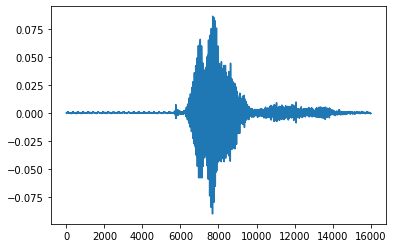

In [135]:
plt.plot(waveform_np)

In [146]:
sr=16000

In [173]:
spectrogram = audio_ops.audio_spectrogram(
    waveform.audio, 
    magnitude_squared=True, 
    window_size=int(40.0 * sr / 1000), 
    stride=int(20.0 * sr / 1000)
)

In [174]:
spectrogram.shape

TensorShape([1, 49, 513])

In [166]:
spectrogram = tf.cast(spectrogram, float)

In [167]:
spect_np = spectrogram.numpy()

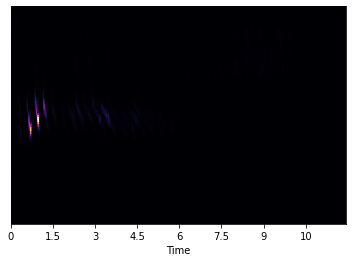

In [168]:
librosa.display.specshow(spect_np[0], x_axis='time')

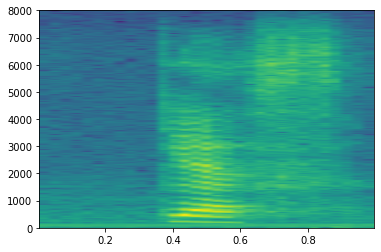

In [140]:
res = plt.specgram(wav_data, Fs=sr, NFFT=int(0.04 * sr))


In [131]:
res[0].shape

(321, 31)

In [175]:
mfcc = audio_ops.mfcc(
            spectrogram=spectrogram,
            sample_rate=sr,
            upper_frequency_limit=7000.0,
            lower_frequency_limit=20.0,
            filterbank_channel_count=40,
            dct_coefficient_count=20)

In [176]:
mfcc = tf.squeeze(mfcc, axis=0)

In [177]:
mfcc.shape

TensorShape([49, 20])

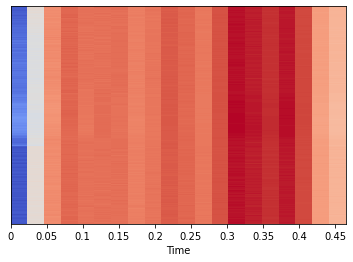

In [253]:
librosa.display.specshow(mfcc.numpy(), x_axis='time')

In [254]:
len(data_1), len(data_2)

(22050, 22050)

In [11]:
p_aug = {
    'gaussian': 1,
    'stretch': 0.4,
    'pitch_shift': 0.4,
    'shift': 1,
    'clipping': 0.4,
    'time_mask': 0.5,
    'freq_mask': 0.5
}

In [194]:
X, Y = make_batch(df, lb,  '../../spotter_data/_background_noise_', noise_to_data, 64, sr, p_aug, "tensorflow")

In [195]:
X.shape

(64, 49, 20, 1)

In [91]:
mfcc = X[0, :, :, 0]

In [299]:
mfcc.shape

(1101, 20)

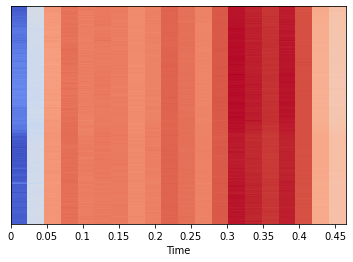

In [301]:
librosa.display.specshow(mfcc, x_axis='time')

In [46]:
librosa.feature.mfcc()

AttributeError: module 'librosa' has no attribute 'mfcc'